## Установка и импорт библиотек

In [ ]:
!pip install pymorphy3

In [ ]:
!pip install datasets

In [61]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GRU
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from google.colab import drive
from sklearn.model_selection import train_test_split
import nltk
import pymorphy3
from nltk.corpus import stopwords
import re
from datasets import load_dataset
from collections import Counter
from nltk.probability import FreqDist
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import json
%matplotlib inline

In [6]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [8]:
drive.mount('/content/drive')

Mounted at /content/drive


## Константы

In [9]:
max_sequence_length = 150
random_state = 42
embedding_dim = 100
input_length = 150
NUM_EPOCHS = 20
BATCH_SIZE = 64
LEARNING_RATE = 0.001

## Загрузка датасета и его обзор

In [10]:
train_dataset = load_dataset("d0rj/rudetoxifier_data", split="train")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/163187 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [160]:
df_train = train_dataset.to_pandas()
df_train

,text,toxic
0,дворника надо тоже уничтожить!,1.0
1,"моя старшая неделю шипела, не принимала подкид...",0.0
2,полностью с вами согласна!,0.0
3,"хоть ногу вверх, ничего не изменится",0.0
4,а что значит - левого ребенка?,0.0
...,...,...
163182,Вонючий совковый скот прибежал и ноет. А вот и...,1.0
163183,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0
163184,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0
163185,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0


In [12]:
df_train['toxic'] = df_train['toxic'].astype(int)

In [13]:
df_train.shape

(163187, 2)

In [14]:
df_train, df_test = train_test_split(df_train, test_size = 0.3, random_state = random_state)

In [15]:
print(df_train.shape)
print(df_test.shape)

(114230, 2)
(48957, 2)


## Предобработка

In [16]:
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

In [17]:
stop_words = stopwords.words("russian")

In [18]:
morph = pymorphy3.MorphAnalyzer()

In [19]:
def clean_text(text):
    pattern = re.compile(r'[А-Яа-я]+', re.UNICODE)
    words = re.findall(pattern, text)
    cleaned_text = ' '.join(words)
    return cleaned_text

In [20]:
def remove_stopwords(text):
    words = nltk.word_tokenize(text, language='russian')
    filtered_words = [word for word in words if word.lower() not in stop_words]
    filtered_text = ' '.join(filtered_words)
    return filtered_text

In [21]:
def lemmatize_text(text):
    words = text.split()
    lemmatized_words = [morph.parse(word)[0].normal_form for word in words]
    return ' '.join(lemmatized_words)

In [22]:
def preprocess_text(text):
    text = clean_text(text)
    text = remove_stopwords(text)
    text = lemmatize_text(text)
    return text

In [23]:
df_train_copy['text'] = df_train_copy['text'].apply(preprocess_text)

In [24]:
df_test_copy['text'] = df_test_copy['text'].apply(preprocess_text)

### Подсчет уникальных слов

In [25]:
all_text = ' '.join(df_train_copy['text'])

In [26]:
all_words = nltk.word_tokenize(all_text, language='russian')

In [27]:
word_freq = FreqDist(all_words)

In [28]:
count_words = len(word_freq)
print(f"Количество уникальных слов: {count_words}")

Количество уникальных слов: 80819


### Токенизация

In [29]:
tokenizer = Tokenizer(num_words=count_words+1000, oov_token="<OOV>")

In [30]:
tokenizer.fit_on_texts(df_train_copy['text'])

In [62]:
tokenizer_config = tokenizer.to_json() # Сохраняем конфиг токенизатора

with open("tokenizer_config.json", "w", encoding="utf-8") as json_file:
    json.dump(tokenizer_config, json_file, ensure_ascii=False)

In [32]:
train_sequences = tokenizer.texts_to_sequences(df_train_copy['text'])
test_sequences = tokenizer.texts_to_sequences(df_test_copy['text'])

In [33]:
train_padded = pad_sequences(train_sequences, maxlen=max_sequence_length, padding = 'post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_sequence_length, padding = 'post', truncating='post')

In [34]:
print(train_padded.shape)
print(test_padded.shape)

(114230, 150)
(48957, 150)


In [35]:
train_labels = df_train_copy['toxic']
test_labels = df_test_copy['toxic']

In [36]:
test_padded

array([[2797,    0,    0, ...,    0,    0,    0],
       [1869,   59,  598, ...,    0,    0,    0],
       [ 127,  160,   12, ...,    0,    0,    0],
       ...,
       [  44,  227,  301, ...,    0,    0,    0],
       [3056,    1,  230, ...,    0,    0,    0],
       [ 569,    0,    0, ...,    0,    0,    0]], dtype=int32)

In [37]:
test_labels

19468     0
93936     0
151930    0
58356     0
126099    0
         ..
24360     1
152924    0
147249    0
131678    0
111553    0
Name: toxic, Length: 48957, dtype: int64

## Создание и обучение нейросети GRU

In [38]:
VOCAB_SIZE = count_words+5

In [162]:
model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=embedding_dim, input_length=input_length))
model.add(GRU(32))
model.add(Dense(1, activation='sigmoid'))

In [163]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [164]:
history = model.fit(train_padded,
                    train_labels,
                    epochs=NUM_EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_split=0.2,
                    verbose = 1)

Epoch 1/20
1428/1428 [==============================] - 67s 46ms/step - loss: 0.4902 - accuracy: 0.8087 - val_loss: 0.4940 - val_accuracy: 0.8046
Epoch 2/20
1428/1428 [==============================] - 23s 16ms/step - loss: 0.4886 - accuracy: 0.8088 - val_loss: 0.4942 - val_accuracy: 0.8046
Epoch 3/20
1428/1428 [==============================] - 21s 14ms/step - loss: 0.4884 - accuracy: 0.8089 - val_loss: 0.4948 - val_accuracy: 0.8046
Epoch 4/20
1428/1428 [==============================] - 18s 13ms/step - loss: 0.4882 - accuracy: 0.8089 - val_loss: 0.4940 - val_accuracy: 0.8046
Epoch 5/20
1428/1428 [==============================] - 18s 12ms/step - loss: 0.4881 - accuracy: 0.8089 - val_loss: 0.4940 - val_accuracy: 0.8046
Epoch 6/20
1428/1428 [==============================] - 18s 12ms/step - loss: 0.4882 - accuracy: 0.8089 - val_loss: 0.4940 - val_accuracy: 0.8046
Epoch 7/20
1428/1428 [==============================] - 16s 11ms/step - loss: 0.4880 - accuracy: 0.8089 - val_loss: 0.4941 -

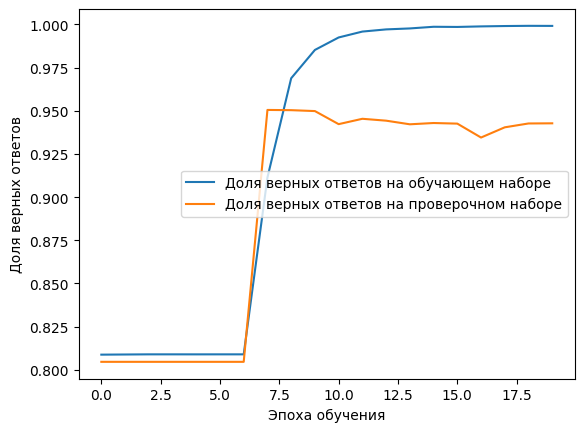

In [165]:
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

### Проверка модели

In [166]:
scores = model.evaluate(test_padded, test_labels, verbose=1)

1530/1530 [==============================] - 12s 8ms/step - loss: 0.3612 - accuracy: 0.9413


In [167]:
tt = 'поздравляю доченьку аземша светлану с днём рождения!!! счастья тебе дорогая моя'
ttp = preprocess_text(tt)
sqee = tokenizer.texts_to_sequences([ttp])
pdd = pad_sequences(sqee, maxlen=150, padding = 'post', truncating='post')

In [168]:
result = model.predict(pdd)
result = "{:.10f}".format(result[0][0])
result

1/1 [==============================] - 0s 300ms/step


'0.0000181174'

In [51]:
#model.save("drive/MyDrive/ta_model")